# Notebook to plot the standard deviation of the fluxes at the ocean-ice interface.

Import and start dask client. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45429,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40279,Total threads: 1
Dashboard: http://127.0.0.1:44376/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54347,


In [4]:
from utils import Import_Expt_Front, date_fmt

Load the data using the Import_Expt_Front, that allows to open all the experiments within a folder ath the same time.

### Important!  
the folder names within the folder path of the experiments must contain the name "expt_XXX". 

i.e.
`
expt_000 expt_001 expt_002 expt_front_0
`

In [5]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_formation_4.2.0_output/'
EXF = Import_Expt_Front(folder)

Define the experiments to ignore in the list `exp_filter`, in this case, ignore the experiments with no ice velocities.

In [6]:
exp_filter = ['expt_front_1_noICEvel','expt_front_05_noICEvel']

Slice data on time to contain from the 15th of September until the 31st of December of the second year of the simulation

In [7]:
t0 = '0002-09-15'
tf = '0002-12-31'

### Useful functions needed for computing the STD of the fluxes.

In [8]:
# Ignore timesteps in case of overlap between restarts of simulations. 
def Overlap_Clear(ds):
    filename = (ds.encoding['source'])
    if "00020630-00020708" in filename:
        data = ds.isel(time_counter=slice(0,-4)).set_coords(('nav_lat', 'nav_lon'))
    else:
        data = ds.set_coords(('nav_lat', 'nav_lon'))
    return data

import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

def envelope_plot(data,time_slice,ax,color='gray'):
    at= ax.twinx()
    at.plot(time_slice[1:-1],np.ones_like(time_slice[1:-1],dtype=float),color=color,linewidth=4,alpha=0.7,zorder=0)
    at.plot(time_slice[1:-1],np.zeros_like(time_slice[1:-1],dtype=float),color=color,linewidth=4,alpha=0.7,zorder=0)
    at.plot([time_slice[0],time_slice[0]],[0,1],color=color,linewidth=2,alpha=0.7,zorder=0)
    at.plot([time_slice[-1],time_slice[-1]],[0,1],color=color,linewidth=2,alpha=0.7,zorder=0)
    
    at.set_ylim(0,1)
    at.set_yticks([])


## Attention!
### Load the data slowly, since it uses a lot of memory.

In [9]:
dataset_saltflx_3h = EXF.import_multipe_expt('iceflx',vars_of_interest=['sfxice','sfxbog','sfxbom','sfxsum','sfxlam','sfxsni','sfxopw','sfxdyn','sfxbri'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':5})

In [10]:
dataset_saltflx_3h = dataset_saltflx_3h.sel(time_counter=slice(t0,tf)).rolling(time_counter = 8).mean()

In [11]:
# Trim memory
client.run(trim_memory)

{'tcp://127.0.0.1:32841': 1,
 'tcp://127.0.0.1:34840': 1,
 'tcp://127.0.0.1:36675': 1,
 'tcp://127.0.0.1:40279': 1,
 'tcp://127.0.0.1:47530': 1,
 'tcp://127.0.0.1:47548': 1,
 'tcp://127.0.0.1:49310': 1,
 'tcp://127.0.0.1:50076': 1}

In [12]:
t0f = '0002-09-15'
tff = '0002-10-15'
spectra_time_slice = dataset_saltflx_3h.time_counter.sel(time_counter=slice(t0f,tff)).values

In [13]:
mean_saltflx = dataset_saltflx_3h.isel(y=slice(1,-1)).mean(('x','y')).compute()

In [14]:
# Trim memory
client.run(trim_memory)

{'tcp://127.0.0.1:32841': 1,
 'tcp://127.0.0.1:34840': 1,
 'tcp://127.0.0.1:36675': 1,
 'tcp://127.0.0.1:40279': 1,
 'tcp://127.0.0.1:47530': 1,
 'tcp://127.0.0.1:47548': 1,
 'tcp://127.0.0.1:49310': 1,
 'tcp://127.0.0.1:50076': 1}

In [15]:
std_saltflx = dataset_saltflx_3h.isel(y=slice(1,-1)).std(('x','y')).compute()

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome

In [16]:
std_saltflx.to_netcdf(folder+'/postprocessed/total_saltflux_variance.nc')

In [17]:
client.run(trim_memory)

{'tcp://127.0.0.1:32841': 1,
 'tcp://127.0.0.1:34840': 1,
 'tcp://127.0.0.1:36675': 1,
 'tcp://127.0.0.1:40279': 1,
 'tcp://127.0.0.1:47530': 1,
 'tcp://127.0.0.1:47548': 1,
 'tcp://127.0.0.1:49310': 1,
 'tcp://127.0.0.1:50076': 1}

In [18]:
dataset_ocehtflx_3h = EXF.import_multipe_expt('grid_FLX', vars_of_interest=['qt_oce','qns_oce'], expt_filter=exp_filter, freq='3h', preprocess=Overlap_Clear, chunks={'time_counter':5})

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [19]:
vars_of_interest = ['siqt','siqns','siqtatm','siqtocean']

In [20]:
dataset_icefor_3h = EXF.import_multipe_expt('icefor',vars_of_interest=vars_of_interest,expt_filter=exp_filter,freq='3h',preprocess=Overlap_Clear,chunks={'time_counter':5})

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [21]:
vars_of_interest = ['hfxbog','hfxopw']

In [22]:
dataset_icehfx_3h = EXF.import_multipe_expt('icehfx',vars_of_interest=vars_of_interest,expt_filter=exp_filter,freq='3h',preprocess=Overlap_Clear,chunks={'time_counter':5})

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [23]:
dataset_htflx_3h = xr.merge((dataset_ocehtflx_3h,dataset_icehfx_3h))

In [24]:
dataset_htflx_3h = dataset_htflx_3h.sel(time_counter=slice(t0,tf)).rolling(min_periods=4, time_counter = 8).mean(skipna=True)

In [25]:
mean_htflux = dataset_htflx_3h.mean(('y','x')).compute()

In [26]:
client.run(trim_memory)

{'tcp://127.0.0.1:32841': 1,
 'tcp://127.0.0.1:34840': 1,
 'tcp://127.0.0.1:36675': 1,
 'tcp://127.0.0.1:40279': 1,
 'tcp://127.0.0.1:47530': 1,
 'tcp://127.0.0.1:47548': 1,
 'tcp://127.0.0.1:49310': 1,
 'tcp://127.0.0.1:50076': 1}

In [27]:
std_htflx = dataset_htflx_3h.std(('y','x')).compute()

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home1/datahome

In [28]:
# std_htflx_e =  ( dataset_htflx_3h.isel(y=slice(1,-1)) -  dataset_htflx_3h.isel(y=slice(1,-1)).mean('x') ).std(('x','y')).compute()

In [29]:
std_htflx.to_netcdf(folder+'/postprocessed/total_heatflux_variance.nc')

In [30]:
client.run(trim_memory)

{'tcp://127.0.0.1:32841': 1,
 'tcp://127.0.0.1:34840': 1,
 'tcp://127.0.0.1:36675': 1,
 'tcp://127.0.0.1:40279': 1,
 'tcp://127.0.0.1:47530': 1,
 'tcp://127.0.0.1:47548': 1,
 'tcp://127.0.0.1:49310': 1,
 'tcp://127.0.0.1:50076': 1}

Print the standard deviation for the open water fluxes for each experiment

In [31]:
print(std_saltflx['sfxopw_front_0'].where(std_saltflx['sfxopw_front_0']!=0).mean())
print(std_saltflx['sfxopw_front_05_noTf'].where(std_saltflx['sfxopw_front_05_noTf']!=0).mean())
print(std_saltflx['sfxopw_front_1_noTf'].where(std_saltflx['sfxopw_front_1_noTf']!=0).mean())

<xarray.DataArray 'sfxopw_front_0' ()> Size: 4B
array(2.1653472e-08, dtype=float32)
<xarray.DataArray 'sfxopw_front_05_noTf' ()> Size: 4B
array(5.033642e-08, dtype=float32)
<xarray.DataArray 'sfxopw_front_1_noTf' ()> Size: 4B
array(6.515233e-08, dtype=float32)


hfxbog_front_0
hfxbog_front_05_noTf
hfxbog_front_1_noTf
hfxopw_front_0
hfxopw_front_05_noTf
hfxopw_front_1_noTf
qt_oce_front_0
qt_oce_front_05_noTf
qt_oce_front_1_noTf


/dev/shm/pbs.2157187.datarmor0/ipykernel_25985/470184285.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1,0].set_xticklabels(updated_labels)
/dev/shm/pbs.2157187.datarmor0/ipykernel_25985/470184285.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1,1].set_xticklabels(updated_labels)


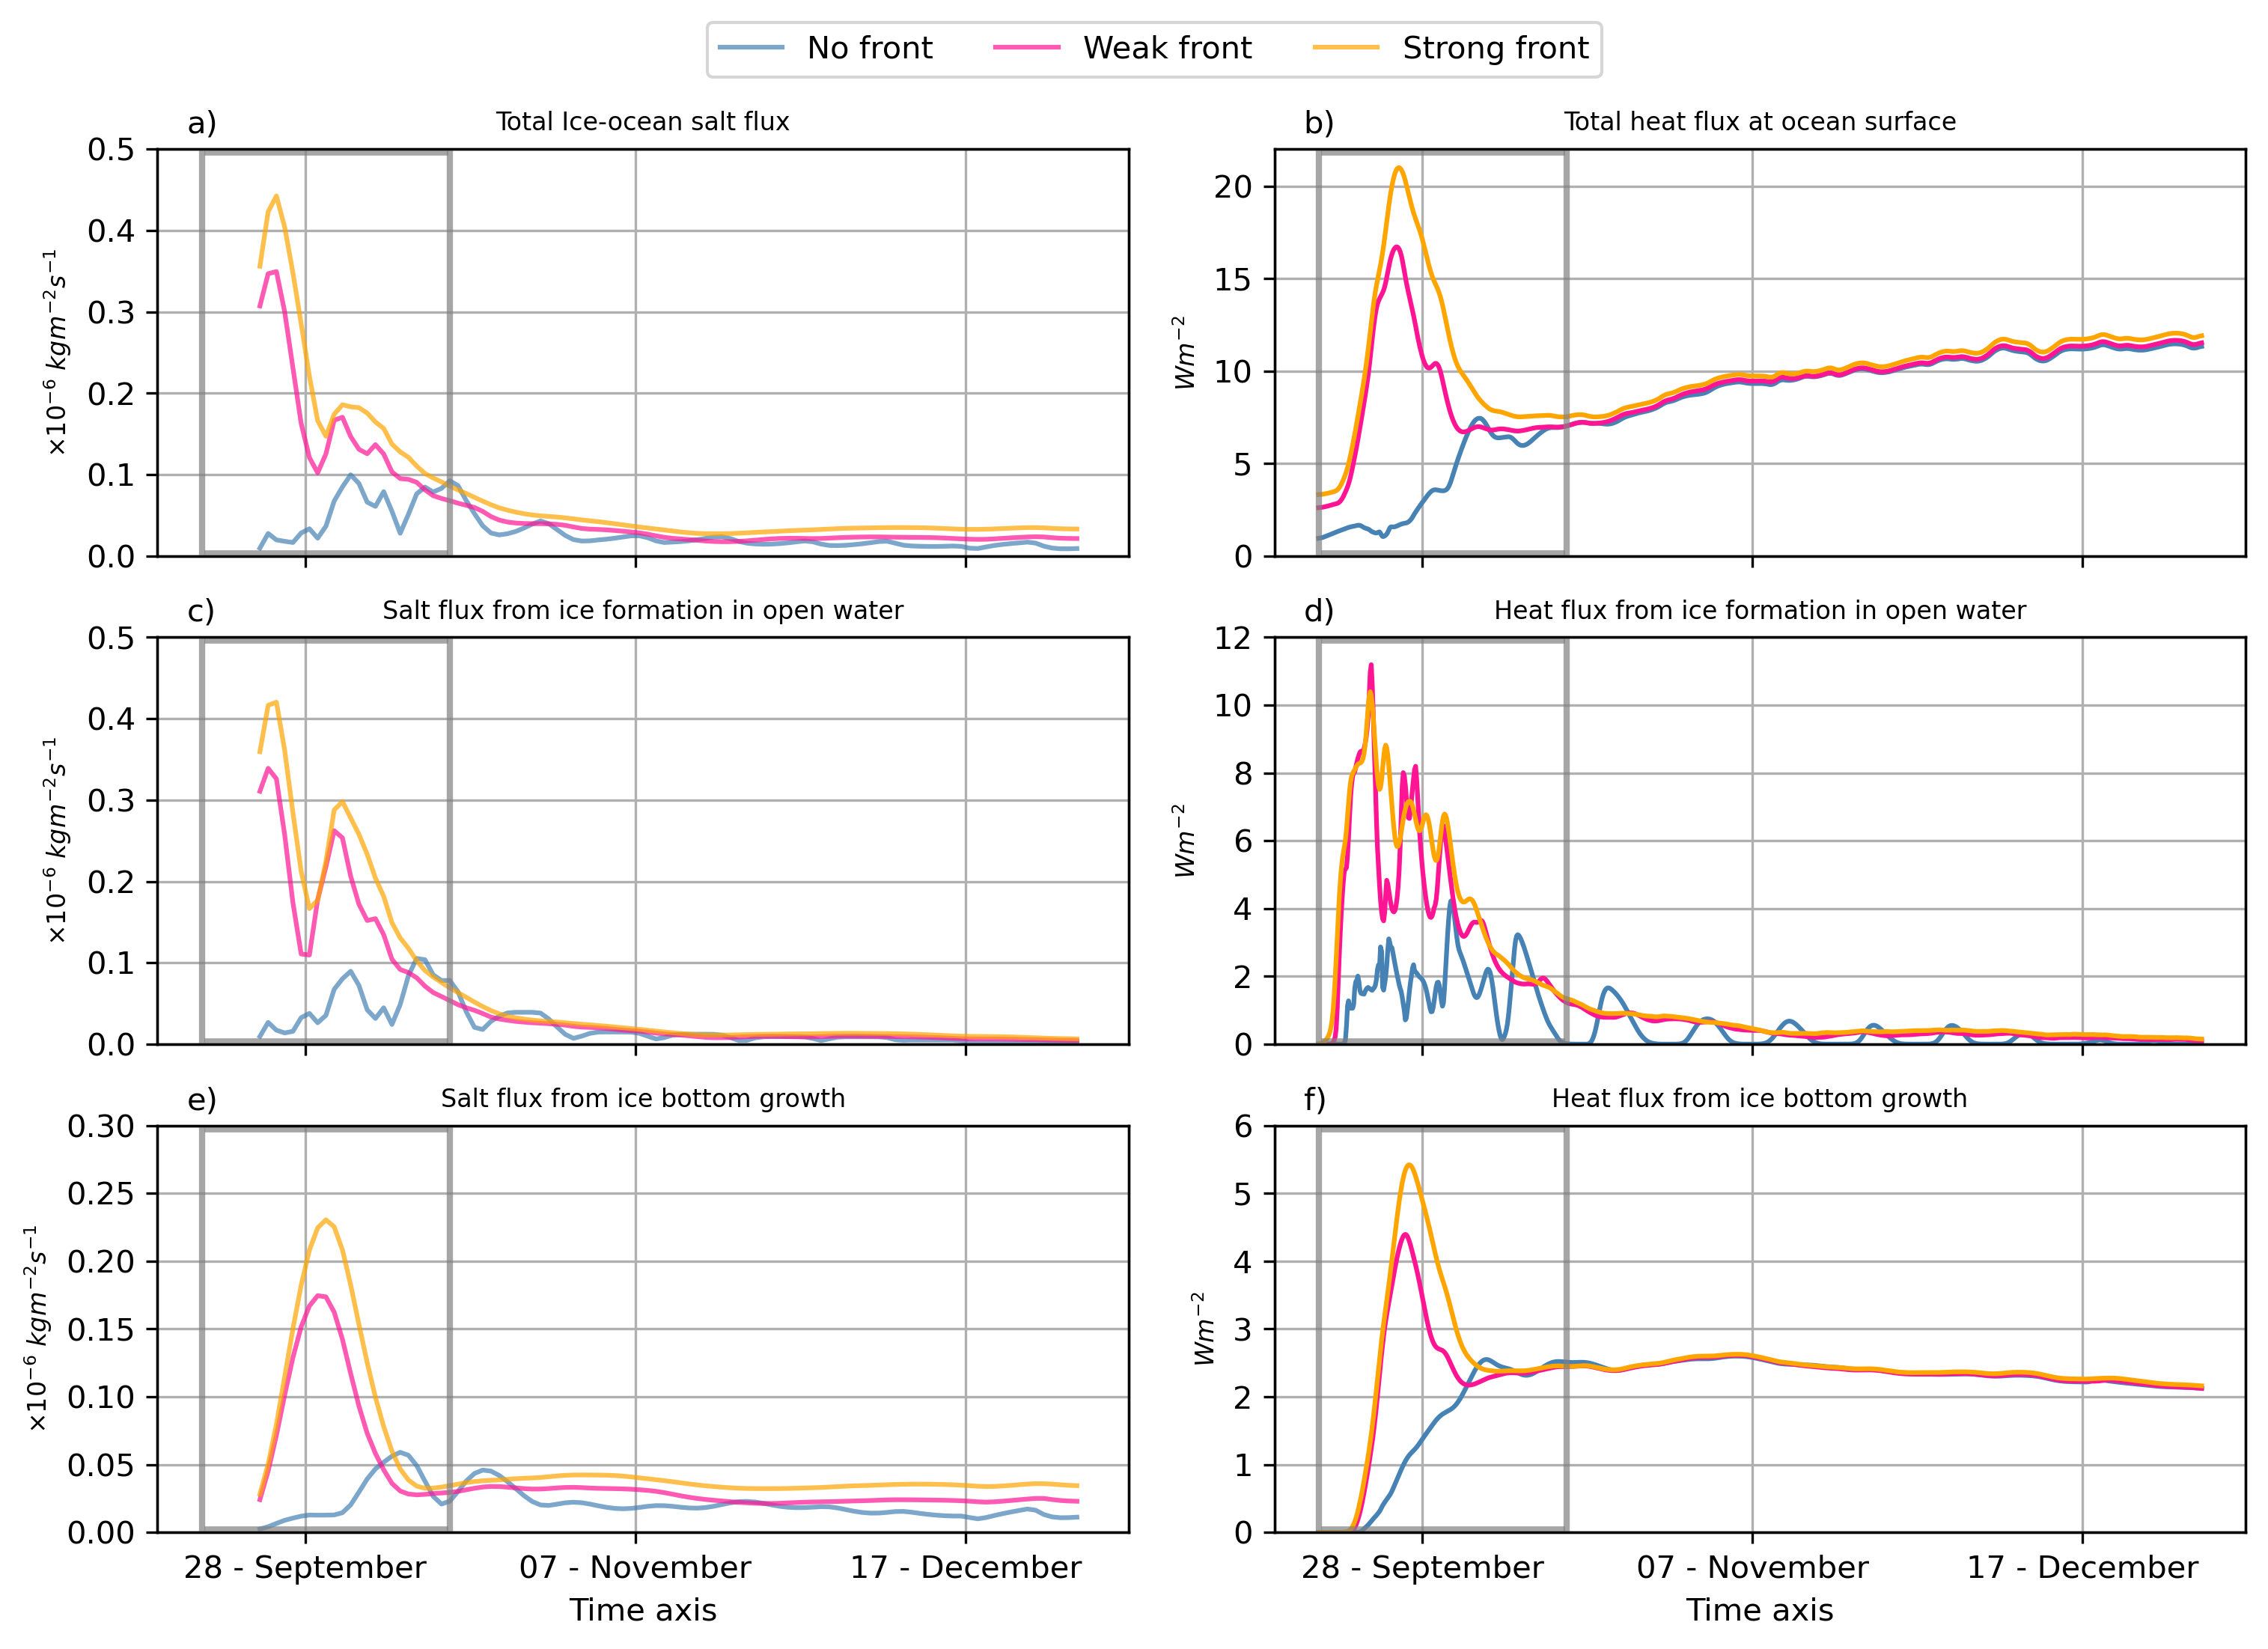

In [32]:
L1 = 10; L2 = 2*np.pi*L1

list_vars = sorted([var for var in list(std_saltflx.data_vars)[:]])#[::-1]
var_uniques = ['sfxice', 'sfxopw', 'sfxbog']
exp_uniques = list(np.unique([var.split('t_')[-1] for var in list_vars]))
# exp_percent = np.array([ int(exp)*10**(2-np.round(np.log10(int(exp)))) if np.log10(int(exp)) < 1.0 else int(exp) for exp in exp_uniques ])
# exp_percent[np.isnan(exp_percent)]=0

exp_percent = ["No","Weak","Strong"]

fontsize=16
fig, axs = plt.subplots(len(var_uniques), 2, figsize=(12,8), dpi=300,sharex=True)
color=['steelblue','deeppink','orange']

ax = axs[:,0]

for var in list_vars:
    var_uniq = np.unique(var.split('_')[0])
    exp = np.unique(var.split('t_')[-1])
    if var_uniq in var_uniques:
        ii = var_uniques.index(var_uniq)
        ex = exp_uniques.index(exp)
        saltflx =  std_saltflx[var]*1e6
#         ax[ii].fill_between(saltflx.time_counter.values,std_saltflx[var]*0,std_saltflx[var]*1e6,color=color[ex],alpha=0.7,label='{0} front'.format(exp_percent[ex]))
        ax[ii].plot(saltflx.time_counter.values,std_saltflx[var]*1e6,color=color[ex],alpha=0.7,label='{0} front'.format(exp_percent[ex]))
        (0*saltflx).plot(ax=ax[ii],linewidth=1,color=color[ex],zorder=3,alpha=0)
        ax[ii].set_ylabel('')
#         ax[ii].set_title(dataset_saltflx_3h[var].long_name.capitalize(),fontsize=8)
        ax[ii].set_ylabel(r'$\times10^{-6}$ '+'$kg m^{-2} s^{-1}$',fontsize=8)
    

[a.set_xlabel('') for a in ax[:-1]]
ax[0].set_ylim((0,0.5))
ax[1].set_ylim((0,0.5))
ax[2].set_ylim((0,0.3))
[a.grid() for a in ax]

    
[ envelope_plot(saltflx,spectra_time_slice,a) for a in ax ] 

ax[0].legend(loc='upper left', bbox_to_anchor=(0.55, 1.35),ncol=3)

list_vars = sorted([var for var in list(std_htflx.data_vars)[:]])#[::-1]
var_uniques = ['qt_oce','hfxopw','hfxbog']
exp_uniques = list(np.unique([var.split('nt_')[-1] for var in list_vars]))


exp_percent = ["No","Weak","Strong"]

ax = axs[:,1]

color=['steelblue','deeppink','orange']

for var in list_vars:
    var_uniq = np.unique(var.split('_front_')[0])
    exp = np.unique(var.split('nt_')[-1])
    if var_uniq in var_uniques:
        ii = var_uniques.index(var_uniq)
        ex = exp_uniques.index(exp)
        print(var)
        htflx =  std_htflx[var]
#         ax[ii].fill_between(htflx.time_counter.values,std_htflx[var]*0,std_htflx[var],color=color[ex],alpha=0.7,label='{0} front'.format(exp_percent[ex]))
        ax[ii].plot(htflx.time_counter.values,std_htflx[var],color=color[ex],label='{0} front'.format(exp_percent[ex]))
        (0*htflx).plot(ax=ax[ii],linewidth=1,color=color[ex],zorder=3,alpha=0)
        ax[ii].set_ylabel('')
#         ax[ii].set_title(dataset_htflx_3h[var].long_name.capitalize(),fontsize=8)
        ax[ii].set_ylabel(r'$Wm^{-2}$',fontsize=8)
    
[a.set_xlabel('') for a in ax[:-1]]
ax[0].set_ylim((0,22))
ax[1].set_ylim((0,12))
ax[2].set_ylim((0,6))
[a.grid() for a in ax]

[ envelope_plot(htflx,spectra_time_slice,a) for a in ax ] 

plt.draw()

labels = [item.get_text() for item in axs[-1,0].get_xticklabels()]
updated_labels = [ date_fmt(label[5:10]) for label in labels]
axs[-1,0].set_xticklabels(updated_labels)

# labels = [item.get_text() for item in axs[-1,1].get_xticklabels()]
# updated_labels = [ date_fmt(label[5:10]) for label in labels]
axs[-1,1].set_xticklabels(updated_labels)

axs[0,0].text(0.03, 1.04, "a)", fontsize=10, transform=axs[0,0].transAxes)
axs[0,1].text(0.03, 1.04, "b)", fontsize=10, transform=axs[0,1].transAxes)
axs[1,0].text(0.03, 1.04, "c)", fontsize=10, transform=axs[1,0].transAxes)
axs[1,1].text(0.03, 1.04, "d)", fontsize=10, transform=axs[1,1].transAxes)
axs[2,0].text(0.03, 1.04, "e)", fontsize=10, transform=axs[2,0].transAxes)
axs[2,1].text(0.03, 1.04, "f)", fontsize=10, transform=axs[2,1].transAxes)

axs[0,0].set_title("Total Ice-ocean salt flux",fontsize=8)
axs[0,1].set_title("Total heat flux at ocean surface",fontsize=8)
axs[1,0].set_title("Salt flux from ice formation in open water",fontsize=8)
axs[1,1].set_title("Heat flux from ice formation in open water",fontsize=8)
axs[2,0].set_title("Salt flux from ice bottom growth",fontsize=8)
axs[2,1].set_title("Heat flux from ice bottom growth",fontsize=8)

plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.savefig('./figures/Fig_4_mean_salt_heat_flux_expts_front_ts_relevant_std.pdf',dpi=300,bbox_inches='tight')